In [11]:
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


C:\Users\Owner\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [5]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()

In [7]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971668799203706 GHz.


In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [12]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [13]:
def plot_shot_results(job):
    from matplotlib import pyplot as plt
    y_pulse_results = job.result(timeout=120)
    measure_list = y_pulse_results.get_counts()
    zero_list = []
    sum_list = []
    print(measure_list)
    for prob in measure_list:
        s = 0.
        for x in prob:
            s+=prob[x]
        sum_list.append(s)
        try:
            zero_list.append(prob['1'])
        except:
            zero_list.append(0)
    print(zero_list)
    plt.plot(sum_list)
    plt.plot(zero_list, '.')
    plt.show()

In [14]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [15]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [16]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [17]:
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating 

# 1. Define Gaussian Clifford Gates

In [104]:
pi_amp = 0.1338881278135786
x_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='x_pi_pulse')
x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_halfpi_pulse')
minus_x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_minus_halfpi_pulse')
y_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp *1j, 
                              sigma=drive_sigma,
                              name='y_pi_pulse')
y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_halfpi_pulse')
minus_y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_minus_halfpi_pulse')

In [97]:
z_pi_pulse_samples = np.concatenate((x_pi_pulse.samples, y_pi_pulse.samples))
z_pi_pulse = pulse.Waveform(z_pi_pulse_samples, name = 'z_pi_pulse')
z_halfpi_pulse_samples = np.concatenate((y_halfpi_pulse.samples,x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
z_halfpi_pulse =  pulse.Waveform(z_halfpi_pulse_samples, name = 'z_halfpi_pulse')     
hadamard_pulse_samples = np.concatenate((y_halfpi_pulse.samples, x_pi_pulse.samples))
hadamard_pulse =  pulse.Waveform(hadamard_pulse_samples, name = 'hadamard_pulse')  

### (check z gate) - optional

In [77]:
amplitude_detuning_array = np.linspace(0.8, 1.2, 40)
schedules = [] 
for amplitude_detuning in amplitude_detuning_array:
    this_schedule = Play(halfpi_pulse, drive_chan)
    this_schedule += Play(pulse.Waveform(z_pi_pulse_samples * amplitude_detuning), drive_chan)
    this_schedule += Play(halfpi_pulse, drive_chan)
    this_schedule += measure << this_schedule.duration
    schedules.append(this_schedule)

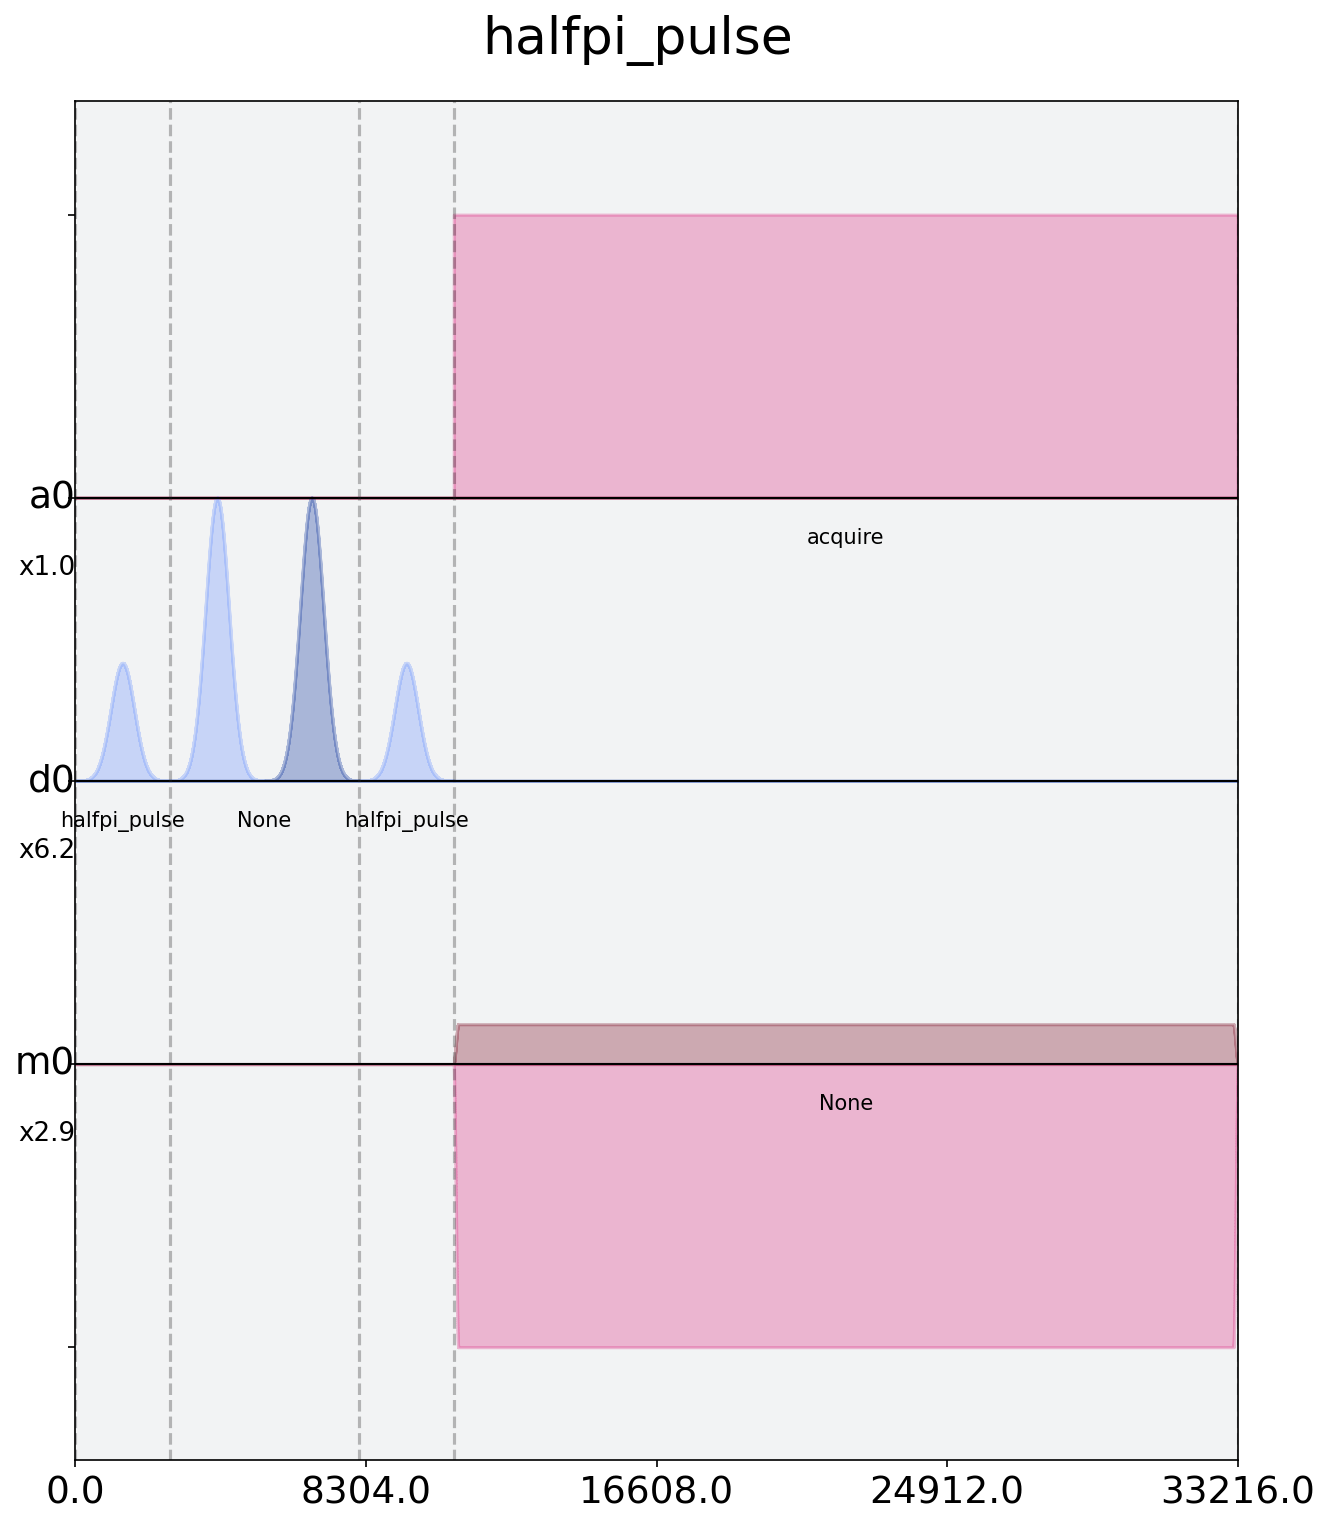

In [78]:
schedules[-1].draw(label = True)

In [79]:
num_shots_per_point = 1024
z_gate_experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los = [{drive_chan:center_frequency_Hz}]
                                                * len(amplitude_detuning_array)
                                 )
from qiskit.tools.monitor import job_monitor
job = backend.run(z_gate_experiment_program)
job_monitor(job)

Job Status: job has successfully run


[{'0': 917, '1': 107}, {'0': 940, '1': 84}, {'0': 952, '1': 72}, {'0': 945, '1': 79}, {'0': 958, '1': 66}, {'0': 963, '1': 61}, {'0': 964, '1': 60}, {'0': 970, '1': 54}, {'0': 966, '1': 58}, {'0': 980, '1': 44}, {'0': 988, '1': 36}, {'0': 985, '1': 39}, {'0': 991, '1': 33}, {'0': 1006, '1': 18}, {'0': 997, '1': 27}, {'0': 993, '1': 31}, {'0': 997, '1': 27}, {'0': 994, '1': 30}, {'0': 1000, '1': 24}, {'0': 998, '1': 26}, {'0': 994, '1': 30}, {'0': 987, '1': 37}, {'0': 979, '1': 45}, {'0': 987, '1': 37}, {'0': 982, '1': 42}, {'0': 975, '1': 49}, {'0': 962, '1': 62}, {'0': 975, '1': 49}, {'0': 960, '1': 64}, {'0': 945, '1': 79}, {'0': 930, '1': 94}, {'0': 931, '1': 93}, {'0': 920, '1': 104}, {'0': 908, '1': 116}, {'0': 893, '1': 131}, {'0': 920, '1': 104}, {'0': 866, '1': 158}, {'0': 866, '1': 158}, {'0': 855, '1': 169}, {'0': 830, '1': 194}]
[107, 84, 72, 79, 66, 61, 60, 54, 58, 44, 36, 39, 33, 18, 27, 31, 27, 30, 24, 26, 30, 37, 45, 37, 42, 49, 62, 49, 64, 79, 94, 93, 104, 116, 131, 104

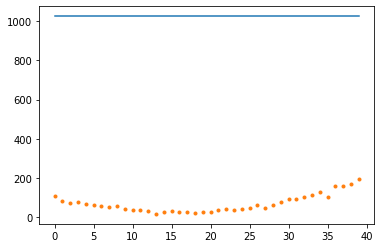

In [80]:
plot_shot_results(job)

In [89]:
measure_list = job.result().get_counts()
print(measure_list)
ones = [x['1'] for x in measure_list]
amplitude_multiplier = amplitude_detuning_array[np.argmin(ones)]
print("amplitude_multiplier = {}".format(amplitude_multiplier))

[{'0': 917, '1': 107}, {'0': 940, '1': 84}, {'0': 952, '1': 72}, {'0': 945, '1': 79}, {'0': 958, '1': 66}, {'0': 963, '1': 61}, {'0': 964, '1': 60}, {'0': 970, '1': 54}, {'0': 966, '1': 58}, {'0': 980, '1': 44}, {'0': 988, '1': 36}, {'0': 985, '1': 39}, {'0': 991, '1': 33}, {'0': 1006, '1': 18}, {'0': 997, '1': 27}, {'0': 993, '1': 31}, {'0': 997, '1': 27}, {'0': 994, '1': 30}, {'0': 1000, '1': 24}, {'0': 998, '1': 26}, {'0': 994, '1': 30}, {'0': 987, '1': 37}, {'0': 979, '1': 45}, {'0': 987, '1': 37}, {'0': 982, '1': 42}, {'0': 975, '1': 49}, {'0': 962, '1': 62}, {'0': 975, '1': 49}, {'0': 960, '1': 64}, {'0': 945, '1': 79}, {'0': 930, '1': 94}, {'0': 931, '1': 93}, {'0': 920, '1': 104}, {'0': 908, '1': 116}, {'0': 893, '1': 131}, {'0': 920, '1': 104}, {'0': 866, '1': 158}, {'0': 866, '1': 158}, {'0': 855, '1': 169}, {'0': 830, '1': 194}]
amplitude_multiplier = 0.9333333333333333


In [114]:
z_pi_pulse = pulse.Waveform(z_pi_pulse_samples * amplitude_multiplier, name = 'z_pi_pulse')

### (check z halfpi gate ) - optional

In [115]:
amplitude_detuning_array = np.linspace(0.90, 0.95, 20)
schedules = [] 
for amplitude_detuning in amplitude_detuning_array:
    this_schedule = Play(x_halfpi_pulse, drive_chan)
    #
    this_schedule += Play(pulse.Waveform(z_halfpi_pulse.samples * amplitude_detuning), drive_chan)
    #
    this_schedule += Play(y_halfpi_pulse, drive_chan)
    this_schedule += measure << this_schedule.duration
    schedules.append(this_schedule)

In [116]:
num_shots_per_point = 1024
z_gate_experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los = [{drive_chan:center_frequency_Hz}]
                                                * len(amplitude_detuning_array)
                                 )
from qiskit.tools.monitor import job_monitor
job = backend.run(z_gate_experiment_program)
job_monitor(job)

Job Status: job has successfully run


[{'0': 136, '1': 888}, {'0': 123, '1': 901}, {'0': 114, '1': 910}, {'0': 128, '1': 896}, {'0': 119, '1': 905}, {'0': 114, '1': 910}, {'0': 124, '1': 900}, {'0': 135, '1': 889}, {'0': 110, '1': 914}, {'0': 122, '1': 902}, {'0': 103, '1': 921}, {'0': 128, '1': 896}, {'0': 110, '1': 914}, {'0': 87, '1': 937}, {'0': 97, '1': 927}, {'0': 105, '1': 919}, {'0': 98, '1': 926}, {'0': 91, '1': 933}, {'0': 101, '1': 923}, {'0': 120, '1': 904}]
[888, 901, 910, 896, 905, 910, 900, 889, 914, 902, 921, 896, 914, 937, 927, 919, 926, 933, 923, 904]


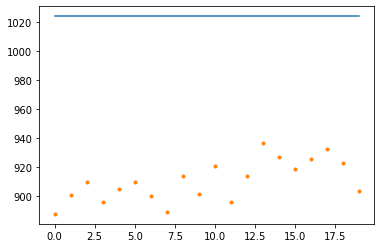

In [117]:
plot_shot_results(job)

In [118]:
measure_list = job.result().get_counts()
print(measure_list)
ones = [x['1'] for x in measure_list]
amplitude_multiplier = amplitude_detuning_array[np.argmax(ones)]
print("amplitude_multiplier = {}".format(amplitude_multiplier))

[{'0': 136, '1': 888}, {'0': 123, '1': 901}, {'0': 114, '1': 910}, {'0': 128, '1': 896}, {'0': 119, '1': 905}, {'0': 114, '1': 910}, {'0': 124, '1': 900}, {'0': 135, '1': 889}, {'0': 110, '1': 914}, {'0': 122, '1': 902}, {'0': 103, '1': 921}, {'0': 128, '1': 896}, {'0': 110, '1': 914}, {'0': 87, '1': 937}, {'0': 97, '1': 927}, {'0': 105, '1': 919}, {'0': 98, '1': 926}, {'0': 91, '1': 933}, {'0': 101, '1': 923}, {'0': 120, '1': 904}]
amplitude_multiplier = 0.9342105263157895


In [120]:
z_halfpi_pulse = pulse.Waveform(z_halfpi_pulse_samples * amplitude_multiplier, name = 'z_halfpi_pulse')

### (check hadamard gate) - optional

In [126]:
amplitude_detuning_array = np.linspace(0.8, 1.2, 20)
schedules = [] 
for amplitude_detuning in amplitude_detuning_array:
    this_schedule = Play(pulse.Waveform(hadamard_pulse.samples * amplitude_detuning), drive_chan)
    this_schedule += Play(y_halfpi_pulse, drive_chan)
    this_schedule += measure << this_schedule.duration
    schedules.append(this_schedule)

In [127]:
num_shots_per_point = 1024
z_gate_experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los = [{drive_chan:center_frequency_Hz}]
                                                * len(amplitude_detuning_array)
                                 )
from qiskit.tools.monitor import job_monitor
job = backend.run(z_gate_experiment_program)
job_monitor(job)

Job Status: job has successfully run


[{'0': 70, '1': 954}, {'0': 73, '1': 951}, {'0': 68, '1': 956}, {'0': 65, '1': 959}, {'0': 76, '1': 948}, {'0': 62, '1': 962}, {'0': 51, '1': 973}, {'0': 58, '1': 966}, {'0': 44, '1': 980}, {'0': 46, '1': 978}, {'0': 47, '1': 977}, {'0': 49, '1': 975}, {'0': 54, '1': 970}, {'0': 57, '1': 967}, {'0': 65, '1': 959}, {'0': 55, '1': 969}, {'0': 74, '1': 950}, {'0': 69, '1': 955}, {'0': 71, '1': 953}, {'0': 82, '1': 942}]
[954, 951, 956, 959, 948, 962, 973, 966, 980, 978, 977, 975, 970, 967, 959, 969, 950, 955, 953, 942]


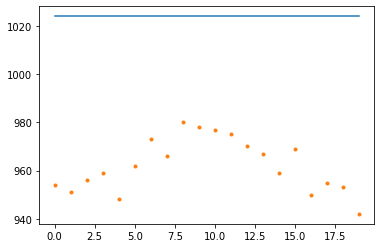

In [128]:
plot_shot_results(job)

In [129]:
measure_list = job.result().get_counts()
print(measure_list)
ones = [x['1'] for x in measure_list]
amplitude_multiplier = amplitude_detuning_array[np.argmax(ones)]
print("amplitude_multiplier = {}".format(amplitude_multiplier))

[{'0': 70, '1': 954}, {'0': 73, '1': 951}, {'0': 68, '1': 956}, {'0': 65, '1': 959}, {'0': 76, '1': 948}, {'0': 62, '1': 962}, {'0': 51, '1': 973}, {'0': 58, '1': 966}, {'0': 44, '1': 980}, {'0': 46, '1': 978}, {'0': 47, '1': 977}, {'0': 49, '1': 975}, {'0': 54, '1': 970}, {'0': 57, '1': 967}, {'0': 65, '1': 959}, {'0': 55, '1': 969}, {'0': 74, '1': 950}, {'0': 69, '1': 955}, {'0': 71, '1': 953}, {'0': 82, '1': 942}]
amplitude_multiplier = 0.968421052631579


In [130]:
hadamard_pulse =  pulse.Waveform(hadamard_pulse_samples * amplitude_multiplier, name = 'hadamard_pulse')  

## Our gaussian clifford gates !

In [149]:
x_pulse = pulse.Waveform(x_pi_pulse.samples, name = 'x_pulse')
y_pulse = pulse.Waveform(y_pi_pulse.samples, name = 'y_pulse')
z_pulse = pulse.Waveform(z_pi_pulse.samples, name = 'z_pulse')
s_pulse = pulse.Waveform(z_halfpi_pulse.samples, name = 's_pulse')
xs_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples))
xs_pulse = pulse.Waveform(xs_pulse_samples, name = 'xs_pulse')
ys_pulse_samples = np.concatenate((minus_y_halfpi_pulse.samples,minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
ys_pulse = pulse.Waveform(ys_pulse_samples, name = 'ys_pulse')
zs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
zs_pulse = pulse.Waveform(zs_pulse_samples, name = 'zs_pulse')
hadamard_pulse = hadamard_pulse
xh_pulse = pulse.Waveform(y_halfpi_pulse.samples, name = 'xh_pulse')
yh_pulse = pulse.Waveform(np.concatenate((x_pi_pulse.samples, y_halfpi_pulse.samples)), name = 'yh_pulse')
zh_pulse = pulse.Waveform(minus_y_halfpi_pulse.samples, name = 'zh_pulse')
sh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples)), name = 'sh_pulse')
xsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,minus_y_halfpi_pulse.samples, x_pi_pulse.samples))
xsh_pulse = pulse.Waveform(xsh_pulse_samples, name = 'xsh_pulse')
ysh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples)), name = 'ysh_pulse')
zsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples, x_pi_pulse.samples))
zsh_pulse = pulse.Waveform(zsh_pulse_samples, name = 'zsh_pulse')
hs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples)), name = 'hs_pulse')
xhs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples)), name = 'xhs_pulse')
yhs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, y_pi_pulse.samples))
yhs_pulse = pulse.Waveform(yhs_pulse_samples, name = 'yhs_pulse')
zhs_pulse_samples =  np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples, y_pi_pulse.samples))
zhs_pulse = pulse.Waveform(zhs_pulse_samples, name= 'zhs_pulse')
shs_pulse = pulse.Waveform(minus_x_halfpi_pulse.samples, name= 'shs_pulse')
xshs_pulse = pulse.Waveform(x_halfpi_pulse.samples, name= 'xshs_pulse')
yshs_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'yshs_pulse')
zshs_pulse = pulse.Waveform(np.concatenate((x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'zshs_pulse')


SyntaxError: invalid syntax (<ipython-input-149-d0a7811dc412>, line 17)

In [140]:
gaussian_clifford_gates = [
x_pulse,\
y_pulse,\
z_pulse,\
s_pulse,\
,\
y_pi_pulse,\
]

In [142]:
gaussian_clifford_gates[1].name

'y_pi_pulse'